In [1]:
import numpy as np
import mnist
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


In [2]:
x_train, y_train, x_test, y_test = mnist.load()
nb_classes = 10
y_train_one_hote = np.eye(nb_classes)[y_train]
y_test_one_hote = np.eye(nb_classes)[y_test]
x_train = x_train/255.0
x_test = x_test/255.0

In [10]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoid_der(z):
    sig = sigmoid(z)
    return sig * (1 - sig)

def relu(z):
    return np.maximum(0,z)

def relu_der(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x
    
def softmax(z):  
    expZ = np.exp(z)
    return expZ / expZ.sum()



def print_architecture(kwargs):
    sizes = [kwargs["input_x_shape"]]
    sizes.extend(kwargs["num_units"])

    for i in range(kwargs["num_layers"]):
        print("Dense_{0}---num_units = {1}, activation = {2}".format(i,kwargs["num_units"][i],kwargs["activations"][i]))
        print("\n")
        

In [11]:
class Network():
    
    def __init__(self,**kwargs):
        self.input_shape = kwargs["input_x_shape"]
        self.num_layers = kwargs["num_layers"]
        
        if len(kwargs["num_units"]) != self.num_layers:
            raise ValueError
        else:
            self.num_units = kwargs["num_units"]
            
        self.W = self.init_weights(kwargs["weights_init_method"])
        self.B = self.init_biases()
        self.activations = self.set_activations(kwargs["activations"])
        
        print_architecture(kwargs)
        
        self.train_loss_history = []
        self.test_loss_history = []
        self.train_acc_history = []
        self.test_acc_history = []


    def init_weights(self,method):
        np.random.seed(1)
        sizes = [self.input_shape]
        sizes.extend(self.num_units)
        W = []
        
        if method == "zeros":
            for i in range(1,len(sizes)):
                W.append(np.zeros((sizes[i],sizes[i-1])))
                
        elif method == "random":
            for i in range(1,len(sizes)):
                W.append(np.random.randn(sizes[i],sizes[i-1])/sizes[i-1])
        return W
    
    def init_biases(self):
        sizes = [self.input_shape]
        sizes.extend(self.num_units)
        B = []
        for i in range(1,len(sizes)):
            B.append(np.zeros((sizes[i],1)))
            
        return B
    
    def set_activations(self,activ_names):
        activations = []
        for name in activ_names:
            if name == "sigmoid":
                activations.append(sigmoid)
            elif name == "relu":
                activations.append(relu)
            elif name == "softmax":
                activations.append(softmax)
            else:
                raise ValueError
                
        return activations

    def delta_cross_entropy(self,A_L,A_L_1,y):  
        nabla_c_w = np.dot(A_L - y,A_L_1.T)
        nabla_c_b = np.sum((A_L - y),axis = 1,keepdims = True) 
        return nabla_c_w, nabla_c_b
        
    def generate_mini_batch(self,X,Y,batch_size):
        idx = np.random.randint(low = 0, high = X.shape[0],size = batch_size)
        return X[idx].T, Y[idx].T
    
    def forward(self,x):
        Z_history = []
        A_history = []
        
        A = x
        A_history.append(A)
        for i in range(self.num_layers):
            Z = np.dot(self.W[i],A) + self.B[i]
            A = self.activations[i](Z)
            Z_history.append(Z)
            A_history.append(A)
            
        return Z_history,A_history
    

    def back_prop(self, X, Y, A_history,Z_history):
 
        nabla_w = [np.zeros(w.shape) for w in self.W]
        nabla_b = [np.zeros(b.shape) for b in self.B] 
        
        A_L = A_history[-1]
        
        delta = A_L - Y
        dW = delta.dot(A_history[-2].T) 
        db = delta

        nabla_w[-1] = dW
        nabla_b[-1] = db
        
        for l in range(2,self.num_layers+1):
            delta = np.dot(self.W[-l+1].T,delta) * sigmoid_der(Z_history[-l])
            delta_nabla_w = np.dot(delta,A_history[-l-1].T)
            nabla_w[-l] = delta_nabla_w
            nabla_b[-l] = delta
        return nabla_w,nabla_b
    

        
    def get_batch_gradients(self,batch,y_true,batch_size):
        
        nabla_w = [np.zeros(w.shape) for w in self.W]
        nabla_b = [np.zeros(b.shape) for b in self.B]
        
        for i in range(batch_size):
            x = batch[:,i].reshape(-1,1)
            y = y_true[:,i].reshape(-1,1)
            
            Z_history,A_history = self.forward(x)
            
            delta_nabla_w,delta_nabla_b = self.back_prop(x, y, A_history, Z_history)
            
            nabla_w = [(nw+dnw)/batch_size for nw, dnw in zip(nabla_w, delta_nabla_w)]
            nabla_b = [(nb+dnb)/batch_size for nb, dnb in zip(nabla_b, delta_nabla_b)]

        return nabla_w,nabla_b
    
    def SGD(self,nabla_w,nabla_b,lr):
        
        self.W = [w - lr*nbl_w for w,nbl_w in zip(self.W,nabla_w)]
        self.B = [b - lr*nbl_b for b,nbl_b in zip(self.B,nabla_b)]
    
    def fit(self,X_train,Y_train,X_test,Y_test,batch_size,lr,num_epochs,num_steps):
        
        for epoch in range(num_epochs):
            
            print("=====================EPOCH{0}======================".format(epoch+1))
            
            for step in range(num_steps):
                
                train_batch, y_train_batch = self.generate_mini_batch(X_train,Y_train,batch_size)

                nabla_w,nabla_b = self.get_batch_gradients(train_batch,y_train_batch,batch_size)
                
                self.SGD(nabla_w,nabla_b,lr)
                
                if step % 100 == 0:
                    
                    curr_loss_train = []
                    curr_loss_test = []

                    curr_acc_train = []
                    curr_acc_test = []
                    
                    test_batch, y_test_batch = self.generate_mini_batch(X_test,Y_test,batch_size)
                    
                    for i in range(test_batch.shape[1]):
                        
                        x_train = train_batch[:,i].reshape(-1,1)
                        y_train = y_train_batch[:,i].reshape(-1,1)

                        x_test = test_batch[:,i].reshape(-1,1)
                        y_test = y_test_batch[:,i].reshape(-1,1)
                        
                        
                        Z_history_test,A_history_test = self.forward(x_test)
                
                        curr_loss_test.append(self.cross_entropy(y_test,A_history_test[-1].T.reshape(-1,1)))
                        curr_acc_test.append(self.accuracy(y_test,A_history_test[-1].T.reshape(-1,1)))
                        
                        Z_history,A_history = self.forward(x_train)
                        
                        curr_loss_train.append(self.cross_entropy(y_train,A_history[-1].T.reshape(-1,1)))
                        curr_acc_train.append(self.accuracy(y_train,A_history[-1].T.reshape(-1,1)))

                    print("Train Loss: ", sum(curr_loss_train)/float(len(curr_loss_train)), "Train Accuracy:", sum(curr_acc_train)/float(len(curr_acc_train)))
                    print("Test Loss:",sum(curr_loss_test)/float(len(curr_loss_test)), "Test Accuracy:", sum(curr_acc_test)/float(len(curr_acc_test)))
                    print("\n")
                    
                    
                if step % 10 == 0:
                    self.train_loss_history.append(sum(curr_loss_train)/float(len(curr_loss_train)))
                    self.test_loss_history.append(sum(curr_loss_test)/float(len(curr_loss_test)))

                    self.train_acc_history.append(sum(curr_acc_train)/float(len(curr_acc_train)))
                    self.test_acc_history.append(sum(curr_acc_test)/float(len(curr_acc_test)))


    
    def predict(self,x):
        z,a = self.forward(x.reshape(-1,1))
        return a[-1].T
        
        
    def predict_batch(self,batch):
        pred = np.zeros((batch.shape[0],self.num_units[-1]))
        for i in range(batch.shape[0]):
            pred[i] = self.predict(batch[i].reshape(-1,1))
        
        return pred
    
    def cross_entropy(self,y,a):
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    
    def accuracy(self,Y_true,Y_pred):
        Y_pred = np.argmax(Y_pred, axis=0)
        Y_true = np.argmax(Y_true, axis=0)

        return (Y_pred == Y_true).mean()
    
    def plot_loss(self):
        plt.figure()
        plt.title("Loss History")
        plt.plot(np.arange(len(self.train_loss_history)), self.train_loss_history)
        plt.xlabel("epochs")
        plt.ylabel("cost")
        plt.plot(np.arange(len(self.test_loss_history)), self.test_loss_history)
        plt.legend(["train","test"])
        plt.show()
        
    def plot_accuracy(self):
        plt.figure()
        plt.title("Accuracy History")
        plt.plot(np.arange(len(self.train_acc_history)), self.train_acc_history)
        plt.xlabel("epochs")
        plt.ylabel("accuracy")
        plt.plot(np.arange(len(self.test_acc_history)), self.test_acc_history)
        plt.legend(["train","test"])
        plt.show()
        
    

In [12]:
net_architectur = {
    "input_x_shape":784,
    "num_layers":2,
    "num_units":[50,10],
    "activations":["sigmoid","softmax"],
    "weights_init_method":"random",
    "loss":"cross_entropy",
}

In [13]:
net = Network(**net_architectur)

Dense_0---num_units = 50, activation = sigmoid


Dense_1---num_units = 10, activation = softmax




In [14]:
net.fit(x_train,y_train_one_hote,x_test,y_test_one_hote,batch_size=50,num_epochs = 10,num_steps=1000,lr=0.1)

=====================EPOCH1======================
Train Loss:  3.2571578659211236 Train Accuracy: 0.1
Test Loss: 3.2584944399194216 Test Accuracy: 0.1


Train Loss:  3.2461356895034226 Train Accuracy: 0.12
Test Loss: 3.2565164924626533 Test Accuracy: 0.08


Train Loss:  3.2561230797876055 Train Accuracy: 0.1
Test Loss: 3.251138505222719 Test Accuracy: 0.08


Train Loss:  3.233903292056271 Train Accuracy: 0.16
Test Loss: 3.259349439920702 Test Accuracy: 0.08


Train Loss:  3.2262968751842855 Train Accuracy: 0.12
Test Loss: 3.214555115156509 Test Accuracy: 0.14




KeyboardInterrupt: 

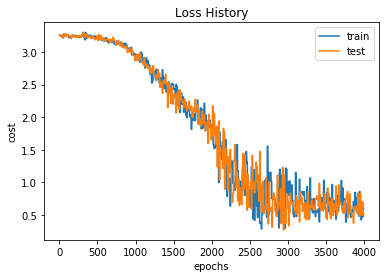

In [161]:
net.plot_loss()

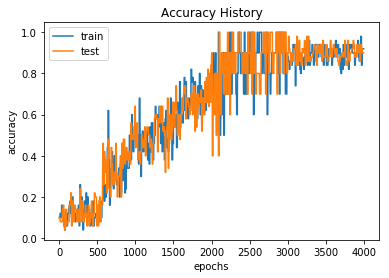

In [162]:
net.plot_accuracy()

In [163]:
test_predict = net.predict_batch(x_test)
y_pred = np.argmax(test_predict,axis=1)

In [164]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.95      0.98      0.96      1135
           2       0.91      0.87      0.89      1032
           3       0.88      0.90      0.89      1010
           4       0.88      0.93      0.90       982
           5       0.84      0.84      0.84       892
           6       0.94      0.91      0.92       958
           7       0.93      0.90      0.91      1028
           8       0.88      0.85      0.86       974
           9       0.89      0.88      0.89      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

